# Black Friday - Prediction

__Problem Statement__ :
>A retail company “ABC Private Limited” wants to understand the customer purchase behaviour (specifically, purchase amount) against various products of different categories. They have shared purchase summary of various customers for selected high volume products from last month.
The data set also contains __customer demographics (age, gender, marital status, city_type, stay_in_current_city)__, product details (product_id and product category) and Total purchase_amount from last month.

>Now, they want to build a model to __predict the purchase amount of customer against various products__ which will help them to create personalized offer for customers against different products. <br>

(Source : Taken directly from Analytics Vidhya Hackahthon contest)
https://datahack.analyticsvidhya.com/contest/black-friday/

### 1.0 Importing required libraries and Data Exploration

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

__About the data__:
> There are 2 csv files train.csv (550068, 13) , test.csv (233599, 12) splitted into  70:30 ratio <br>

> Models can be evaluated on the basis of your prediction of the purchase amount for the test data (test.csv), which contains similar data-points as train data (train.csv) except for their purchase amount. 

In [2]:
# Importing data into python from the given csv file
train = pd.read_csv('../data/BlackFriday/train.csv')
test = pd.read_csv('../data/BlackFriday/test.csv')

In [3]:
# Including new column named 'source' and giving the value as 'train' / 'test' to identify from where exactly the data was taken
train['source']='train'
test['source']='test'

In [4]:
# Combining the 2 dataframes (train and Test) into a single dataframe 'dataset'
dataset = pd.concat([train, test],ignore_index=True, sort=False)
print (train.shape, test.shape, dataset.shape)

(550068, 13) (233599, 12) (783667, 13)


In [5]:
dataset.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,source
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370.0,train
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200.0,train
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422.0,train
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057.0,train
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969.0,train


In [6]:
# Checking for null values in the columns
dataset.isnull().sum()

User_ID                            0
Product_ID                         0
Gender                             0
Age                                0
Occupation                         0
City_Category                      0
Stay_In_Current_City_Years         0
Marital_Status                     0
Product_Category_1                 0
Product_Category_2            245982
Product_Category_3            545809
Purchase                      233599
source                             0
dtype: int64

__Observation__:
There are significant missing values in 3 columns (Product_Category_2, Product_Category_3 and Purchase)

In [7]:
dataset.dtypes

User_ID                         int64
Product_ID                     object
Gender                         object
Age                            object
Occupation                      int64
City_Category                  object
Stay_In_Current_City_Years     object
Marital_Status                  int64
Product_Category_1              int64
Product_Category_2            float64
Product_Category_3            float64
Purchase                      float64
source                         object
dtype: object

In [8]:
# Checking details from the columns with 'numeric' datatype
dataset.describe()

,User_ID,Occupation,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
count,7.836670e+05,783667.000000,783667.000000,783667.000000,537685.000000,237858.000000,550068.000000
mean,1.003029e+06,8.079300,0.409777,5.366196,9.844506,12.668605,9263.968713
std,1.727267e+03,6.522206,0.491793,3.878160,5.089093,4.125510,5023.065394
min,1.000001e+06,0.000000,0.000000,1.000000,2.000000,3.000000,12.000000
25%,1.001519e+06,2.000000,0.000000,1.000000,5.000000,9.000000,5823.000000
50%,1.003075e+06,7.000000,0.000000,5.000000,9.000000,14.000000,8047.000000
75%,1.004478e+06,14.000000,1.000000,8.000000,15.000000,16.000000,12054.000000
max,1.006040e+06,20.000000,1.000000,20.000000,18.000000,18.000000,23961.000000


We can see that most of the columns are with categorical data, either expressed in numericals or strings

In [9]:
# Obtaining number of unique values in each column
dataset.apply(lambda x: len(x.unique()))

User_ID                        5891
Product_ID                     3677
Gender                            2
Age                               7
Occupation                       21
City_Category                     3
Stay_In_Current_City_Years        5
Marital_Status                    2
Product_Category_1               20
Product_Category_2               18
Product_Category_3               16
Purchase                      18106
source                            2
dtype: int64

In [10]:
#Filter categorical variables
categorical_columns = [x for x in dataset.dtypes.index if dataset.dtypes[x]=='object']
# Adding other categorical variables indicated as numerics
categorical_columns.extend(['Occupation'])
categorical_columns

['Product_ID',
 'Gender',
 'Age',
 'City_Category',
 'Stay_In_Current_City_Years',
 'source',
 'Occupation']

In [11]:
# Droping Identifier values from the list
categorical_columns = [x for x in categorical_columns if x not in ['Product_ID','source']]
categorical_columns

['Gender', 'Age', 'City_Category', 'Stay_In_Current_City_Years', 'Occupation']

In [12]:
# Print frequency of categories
for col in categorical_columns:
    print ('Frequency (Count) of Categories for varible : ', col)
    print (dataset[col].value_counts())
    print('---------------------------------------------------')

Frequency (Count) of Categories for varible :  Gender
M    590031
F    193636
Name: Gender, dtype: int64
---------------------------------------------------
Frequency (Count) of Categories for varible :  Age
26-35    313015
36-45    156724
18-25    141953
46-50     65278
51-55     54784
55+       30579
0-17      21334
Name: Age, dtype: int64
---------------------------------------------------
Frequency (Count) of Categories for varible :  City_Category
B    329739
C    243684
A    210244
Name: City_Category, dtype: int64
---------------------------------------------------
Frequency (Count) of Categories for varible :  Stay_In_Current_City_Years
1     276425
2     145427
3     135428
4+    120671
0     105716
Name: Stay_In_Current_City_Years, dtype: int64
---------------------------------------------------
Frequency (Count) of Categories for varible :  Occupation
4     103086
0      98850
7      84127
1      67687
17     57418
20     47840
12     44448
14     38782
2      37996
16     3

### 1.1 Hypothesis

On observations of the column headers and the values the following hypothesis can be carried out

__User_ID__ : <br>
Identification values which links to the demographics of the person like (Gender, Age, Marital Status, Occupation, City Category and years in city) 
<br>

__Product_ID__ : <br>
Identification values which links other sub categories Product_Category_1, Product_Category_2 and Product_Category_3
<br>

__Gender__ : (Male / Female) <br>
Generally females shop more than male. However the User_ID maybe linked with the male who would pay for the purchase
<br>

__Age__ : (Range between 0 to 55+) <br>
Teenagers and middle aged group people tend to make use of the BlackFriday sale
<br>

__Marital Status__ : (Married / Un-married) <br>
Un-married people spend more during the sale season compared to those married
<br>

__Occupation__ : (Range between 0 to 20) <br>
People in Managerial and above position Purchase more compared to mid-level and associate positions
<br>

__City Category__ : (Code A, B, C) <br>
People living in metros spend more during sale compared to less populated cities

__Stay in City__ : (Range between 0 to 4+) <br>
As people stay more in a particular city and based on experience on various aspects in the mart, people who fancy few of their favorite marts may visit them during the sale season.

__Product Category__ : (1, 2, & 3) <br>
Links to Sub categories of Product_ID


### 2. EDA
> Imputing missing values and Treating outliers

In [13]:
# Checking whether Product_ID is related to other Product Category columns
dataset.groupby(['Product_ID'])['Product_Category_1','Product_Category_2','Product_Category_3'].mean().head(20)

,Product_Category_1,Product_Category_2,Product_Category_3
Product_ID,,,
P00000142,3,4.0,5.0
P00000242,2,4.0,9.0
P00000342,5,14.0,NaN
P00000442,5,8.0,NaN
P00000542,5,NaN,NaN
P00000642,1,6.0,16.0
P00000742,5,14.0,NaN
P00000842,2,4.0,NaN
P00000942,1,NaN,NaN


__Observation__: <br>
From the above, we can make out that Product_Category2 and Product_Category3 are __not related__ to the Product_ID

In [14]:
# Obtaining list of booleans specifying Product_Category_2 and Product_Category_3 missing  values
miss_Prod2_rows = dataset['Product_Category_2'].isnull()  
miss_Prod3_rows = dataset['Product_Category_3'].isnull()

In [15]:
# Impute 0s in place of NaN in columns Product_Category_2 and Product_Category_3
dataset.loc[miss_Prod2_rows,'Product_Category_2'] = 0
dataset.loc[miss_Prod3_rows,'Product_Category_3'] = 0

In [16]:
dataset[['Product_ID','Product_Category_1','Product_Category_2','Product_Category_3']].head(10)

,Product_ID,Product_Category_1,Product_Category_2,Product_Category_3
0,P00069042,3,0.0,0.0
1,P00248942,1,6.0,14.0
2,P00087842,12,0.0,0.0
3,P00085442,12,14.0,0.0
4,P00285442,8,0.0,0.0
5,P00193542,1,2.0,0.0
6,P00184942,1,8.0,17.0
7,P00346142,1,15.0,0.0
8,P0097242,1,16.0,0.0
9,P00274942,8,0.0,0.0


In [17]:
# Combining 3 Product category columns into 1 maseter category column
dataset['Master_Product_Category']=dataset['Product_Category_1'].astype(str)+dataset['Product_Category_2'].astype(int).astype(str)+dataset['Product_Category_3'].astype(int).astype(str)


In [18]:
dataset[['Product_ID','Product_Category_1','Product_Category_2','Product_Category_3','Master_Product_Category']].head(10)

,Product_ID,Product_Category_1,Product_Category_2,Product_Category_3,Master_Product_Category
0,P00069042,3,0.0,0.0,300
1,P00248942,1,6.0,14.0,1614
2,P00087842,12,0.0,0.0,1200
3,P00085442,12,14.0,0.0,12140
4,P00285442,8,0.0,0.0,800
5,P00193542,1,2.0,0.0,120
6,P00184942,1,8.0,17.0,1817
7,P00346142,1,15.0,0.0,1150
8,P0097242,1,16.0,0.0,1160
9,P00274942,8,0.0,0.0,800


In [19]:
dataset.isnull().sum()

User_ID                            0
Product_ID                         0
Gender                             0
Age                                0
Occupation                         0
City_Category                      0
Stay_In_Current_City_Years         0
Marital_Status                     0
Product_Category_1                 0
Product_Category_2                 0
Product_Category_3                 0
Purchase                      233599
source                             0
Master_Product_Category            0
dtype: int64

__Purchase column__ : <br>
>There are quire a few missing values in Purchase (dependent varaible) column. <br>
It is advisable to impute as many values in the dependent variable column to obtain a good model.<br>
Hence it is advisable to find whether there is *correlation between the Product_ID or newly created Master Product Category column* and Purchase column.

In [20]:
# Check Purchase values from the grouping by the newly created Master_Product_Category column
categ_mean = dataset.groupby(['Master_Product_Category'])['Purchase'].mean()

In [21]:
categ_mean.isnull().sum()

0

In [22]:
# Check Purchase values from the grouping by the Product_ID column
purch_mean_prodID = dataset.groupby(['Product_ID'])['Purchase'].mean()

In [23]:
purch_mean_prodID.isnull().sum()

46

As the missing values in Purchase column has corresponding Master category values, <br>
incorporating the mean value into the Purchase column based on the Master Category column is advisable.

In [24]:
# Obtain missing Purchase values
miss_Purch_rows = dataset['Purchase'].isnull()

In [25]:
# Impute mean Purchase value based on Master_Product_Category column
dataset.loc[miss_Purch_rows,'Purchase'] = dataset.loc[miss_Purch_rows,'Master_Product_Category'].apply(lambda x: categ_mean.loc[x])

In [26]:
print ('Null values in Purchase column before imputation : ' , miss_Purch_rows.sum())
print ('Results after imputation : ', dataset['Purchase'].isnull().sum())

Null values in Purchase column before imputation :  233599
Results after imputation :  0


In [27]:
dataset.isnull().sum()

User_ID                       0
Product_ID                    0
Gender                        0
Age                           0
Occupation                    0
City_Category                 0
Stay_In_Current_City_Years    0
Marital_Status                0
Product_Category_1            0
Product_Category_2            0
Product_Category_3            0
Purchase                      0
source                        0
Master_Product_Category       0
dtype: int64

In [28]:
list(dataset.columns.values)

['User_ID',
 'Product_ID',
 'Gender',
 'Age',
 'Occupation',
 'City_Category',
 'Stay_In_Current_City_Years',
 'Marital_Status',
 'Product_Category_1',
 'Product_Category_2',
 'Product_Category_3',
 'Purchase',
 'source',
 'Master_Product_Category']

In [29]:
# Rearranging the columns
dataset = dataset[['User_ID','Product_ID', 'Gender','Age','Occupation', 'City_Category','Stay_In_Current_City_Years',
                   'Marital_Status',  'Master_Product_Category', 'Purchase', 'source']]

In [30]:
list(dataset.columns.values)

['User_ID',
 'Product_ID',
 'Gender',
 'Age',
 'Occupation',
 'City_Category',
 'Stay_In_Current_City_Years',
 'Marital_Status',
 'Master_Product_Category',
 'Purchase',
 'source']

In [31]:
dataset.head(10)

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Master_Product_Category,Purchase,source
0,1000001,P00069042,F,0-17,10,A,2,0,300,8370.0,train
1,1000001,P00248942,F,0-17,10,A,2,0,1614,15200.0,train
2,1000001,P00087842,F,0-17,10,A,2,0,1200,1422.0,train
3,1000001,P00085442,F,0-17,10,A,2,0,12140,1057.0,train
4,1000002,P00285442,M,55+,16,C,4+,0,800,7969.0,train
5,1000003,P00193542,M,26-35,15,A,3,0,120,15227.0,train
6,1000004,P00184942,M,46-50,7,B,2,1,1817,19215.0,train
7,1000004,P00346142,M,46-50,7,B,2,1,1150,15854.0,train
8,1000004,P0097242,M,46-50,7,B,2,1,1160,15686.0,train
9,1000005,P00274942,M,26-35,20,A,1,1,800,7871.0,train


In [32]:
dataset.dtypes

User_ID                         int64
Product_ID                     object
Gender                         object
Age                            object
Occupation                      int64
City_Category                  object
Stay_In_Current_City_Years     object
Marital_Status                  int64
Master_Product_Category        object
Purchase                      float64
source                         object
dtype: object

In [33]:
# Converting Master_Product_Category datatype object to integer
dataset['Master_Product_Category'] = dataset['Master_Product_Category'].astype(str).astype(int)

In [34]:
dataset.Gender.unique()

array(['F', 'M'], dtype=object)

In [35]:
#Rename Gender to more intuitive categories:
dataset['Gender'] = dataset['Gender'].map({'F':'Female','M':'Male'})

In [36]:
dataset.Marital_Status.unique()

array([0, 1], dtype=int64)

In [37]:
#Rename them to more intuitive categories:
dataset['Marital_Status'] = dataset['Marital_Status'].map({0:'Un-Married', 1:'Married'})

In [38]:
# Re-look at the unique values of other 'demographical' columns pertaining to the customer
print('Age :' ,sorted(dataset.Age.unique()), sep='\n')
print(sep='\n\n')
print('City_Category :', sorted(dataset.City_Category.unique()), sep='\n')
print(sep='\n\n')
print('Stay_In_Current_City_Years :', sorted(dataset.Stay_In_Current_City_Years.unique()), sep='\n')
print(sep='\n\n')

Age :
['0-17', '18-25', '26-35', '36-45', '46-50', '51-55', '55+']

City_Category :
['A', 'B', 'C']

Stay_In_Current_City_Years :
['0', '1', '2', '3', '4+']



In [39]:
# Replacing '4+' years of with numerical number 4 
dataset['Stay_In_Current_City_Years'] = dataset['Stay_In_Current_City_Years'].replace('4+', 4)

In [40]:
# Converting Stay_In_Current_City_Years data type to integer
dataset['Stay_In_Current_City_Years'] = dataset['Stay_In_Current_City_Years'].astype(str).astype(int)

In [41]:
print('Occupation :', sorted(dataset.Occupation.unique()))

Occupation : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]


__Point to ponder__:

We can observe that there are __(21) categories__ of Occupation of customers. <br>
Based on the country that the data has been taken, there might be standard coding system for categorising occupation, which is been indicated in the dataset.

However, based on International Standard Classification of Occupations, there are (10) main categories
1. Managers
2. Professional
3. Technicians and associate professionals
4. Clerical support workers
5. Service and sales workers
6. Skilled agricultural, forestry and fishery workers
7. Craft and related trades workers
8. Plant and machine operators, and assemblers
9. Elementary occupations
10. Armed forces occupations

(Source : Wikipedia)

### 3. Visualization

Visualization of categorical variables  - __BY COUNT__

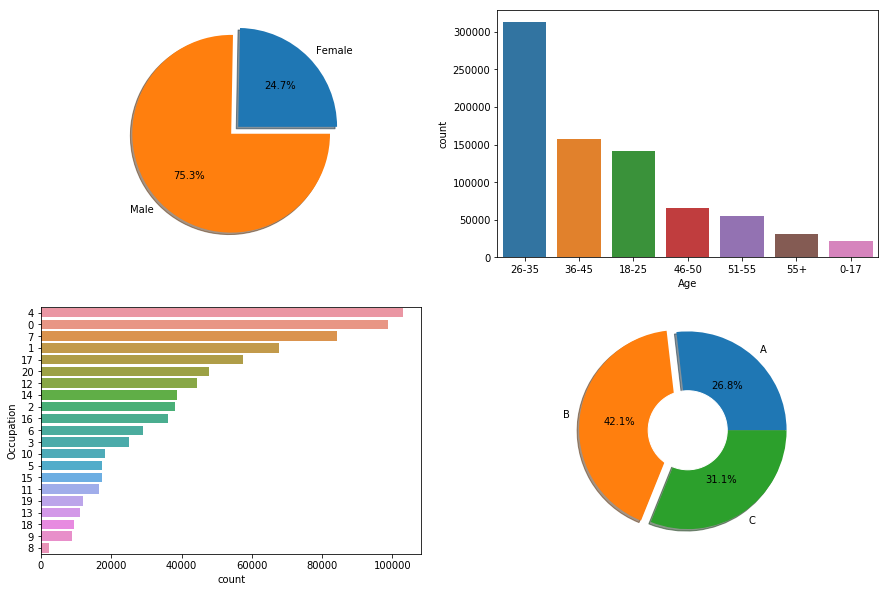

In [42]:
plt.figure(figsize=(15,10))

# Pie chart for gender distribution
plt.subplot(2,2,1)
gender_count = [dataset.Gender[dataset['Gender']=='Female'].count(),
                dataset.Gender[dataset['Gender']=='Male'].count()]
gender_lab = dataset.Gender.unique()
expl = (0.1,0)
plt.pie(gender_count, labels=gender_lab, explode=expl, shadow=True , autopct='%1.1f%%');

# Bar chart for Age
plt.subplot(2,2,2)
ordr =dataset.groupby(["Age"]).count().sort_values(by='Purchase',ascending=False).index
sns.countplot(dataset['Age'], label=True, order=ordr)

# Bar chart for Occupation
plt.subplot(2,2,3)
ordr1 =dataset.groupby(["Occupation"]).count().sort_values(by='Purchase',ascending=False).index
sns.countplot(y=dataset['Occupation'], label=True, order=ordr1)

# Donut chart for City Category
plt.subplot(2,2,4)
city_group = dataset.groupby(["City_Category"])
city_count = city_group[['Purchase']].count().values.tolist()
city_lab = dataset.groupby(["City_Category"]).count().index.values
my_circle = plt.Circle( (0,0), 0.4, color='white')
expl1 = (0,0.1,0)
plt.pie(city_count, labels=city_lab,explode=expl1, shadow=True, autopct='%1.1f%%')
plt.gcf().gca().add_artist(my_circle)


plt.show()

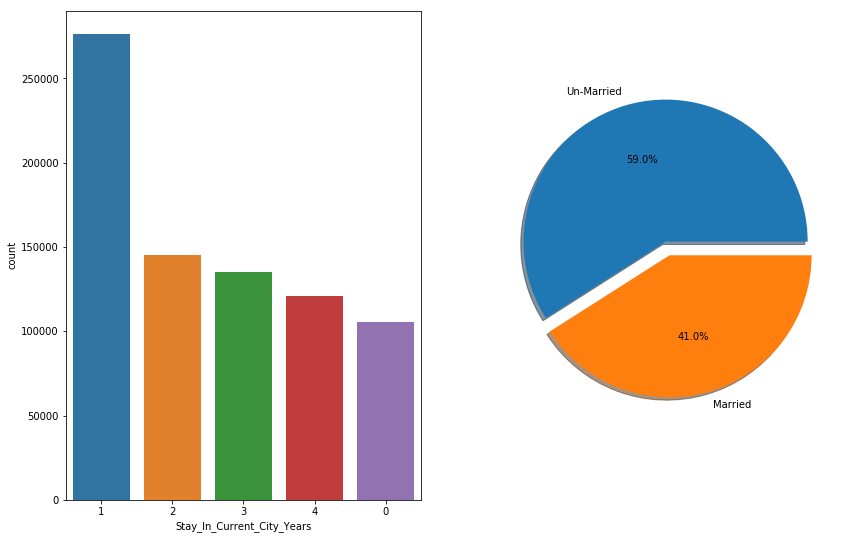

In [43]:
plt.figure(figsize=(14,9))

plt.subplot(1,2,1)
ordr2 =dataset.groupby(["Stay_In_Current_City_Years"]).count().sort_values(by='Purchase',ascending=False).index
sns.countplot(dataset['Stay_In_Current_City_Years'], label=True, order=ordr2)

plt.subplot(1,2,2)
ms_count = [dataset.Marital_Status[dataset['Marital_Status']=='Un-Married'].count(),
                dataset.Marital_Status[dataset['Marital_Status']=='Married'].count()]
ms_lab = dataset.Marital_Status.unique()
expl = (0.1,0)
plt.pie(ms_count, labels=ms_lab, explode=expl, shadow=True , autopct='%1.1f%%');

plt.show()

More Insight from Gender and Age

In [44]:
#Creating new column in the dataset 
dataset['Gender_MaritalStatus'] = dataset.apply(lambda x:'%s_%s' % (x['Gender'],x['Marital_Status']),axis=1)

In [45]:
dataset.Gender_MaritalStatus.unique()

array(['Female_Un-Married', 'Male_Un-Married', 'Male_Married',
       'Female_Married'], dtype=object)

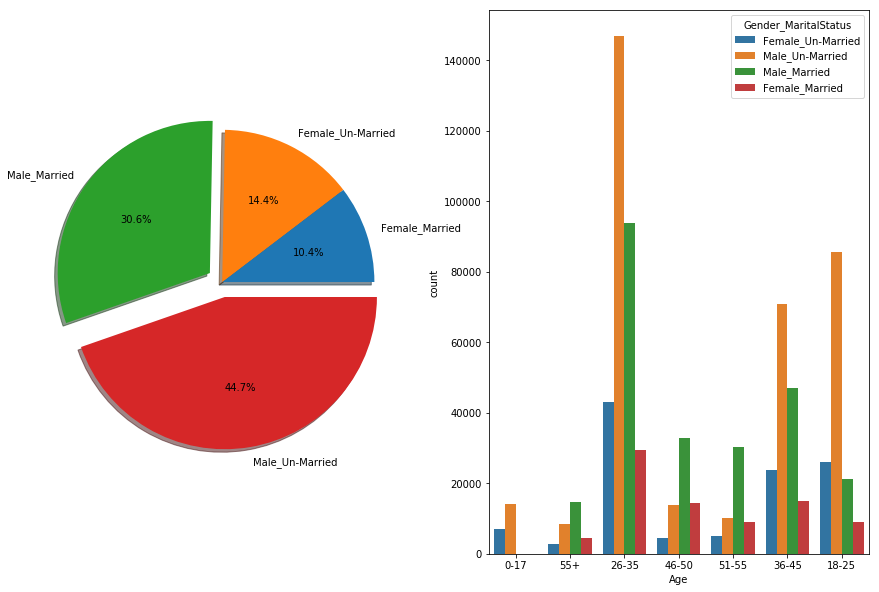

In [46]:
plt.figure(figsize=(15,10))

plt.subplot(1,2,1)
group_g_ms = dataset.groupby(["Gender_MaritalStatus"])
count_ms = group_g_ms[['Purchase']].count().values.tolist()
lab1 = dataset.groupby(["Gender_MaritalStatus"]).count().index.values
expl2 = (0,0,0.1,0.1)

plt.pie(count_ms, labels=lab1,explode=expl2, shadow=True, autopct='%1.1f%%')

plt.subplot(1,2,2)
sns.countplot(dataset['Age'],hue=dataset['Gender_MaritalStatus'])

plt.show()

__Observations__ : 
1. __Un-married males__ between the age group of __26-35__ are major customers of the store.
2. Majority customers are from the __City category B (42%) and C (31%)__
4. Customers with __Occupation__ code __4 (13%), 0 (12.7%) and 7(10.8%)__ are more compared to others
5. It can be observed that, as customers __who are new__ in the the current city, tend to purchase more from the store.

Visualization of categorical variables  - __BY AVERAGE PURCHASE__

c:\users\nags\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 576x432 with 0 Axes>

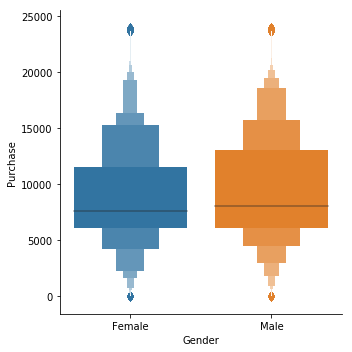

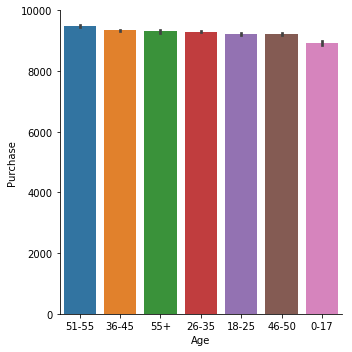

In [47]:
plt.figure(figsize=(8,6))


sns.catplot(x='Gender', y='Purchase', data=dataset, kind='boxen')

ordr_age =dataset.groupby(["Age"]).mean().sort_values(by='Purchase',ascending=False).index
sns.catplot(x='Age', y='Purchase', order=ordr_age, data=dataset, kind='bar')

plt.show()

<Figure size 576x432 with 0 Axes>

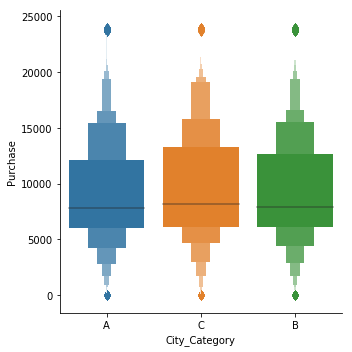

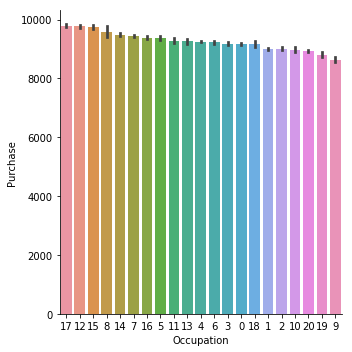

In [48]:
plt.figure(figsize=(8,6))

sns.catplot(x='City_Category', y='Purchase', data=dataset, kind='boxen')

ordr_occ =dataset.groupby(["Occupation"]).mean().sort_values(by='Purchase',ascending=False).index
sns.catplot(x='Occupation', y='Purchase', order=ordr_occ, data=dataset, kind='bar')

plt.show()

__Observations__ : 
1. __Males__ spend more than females
2. Age factor : Customers who are __above 35 years__ of age spend more. 
3. __Occupation codes 17, 12 and 15__ appears to be earning more and accordingly spend more 
4. People living in __Category C__ city appears to spend more on items in the store 


 __Encoding categorical variable for - Correlation Visualation__


In [49]:
# Feature Encoding categorical columns to visualize correlation of parameters with Purchase column
# Importing required package
from sklearn.preprocessing import LabelEncoder
encode_x = LabelEncoder()

In [50]:
# Creating copy of the dataset for this activity
dataset_cat = dataset.copy()

In [51]:
dataset_cat.dtypes

User_ID                         int64
Product_ID                     object
Gender                         object
Age                            object
Occupation                      int64
City_Category                  object
Stay_In_Current_City_Years      int32
Marital_Status                 object
Master_Product_Category         int32
Purchase                      float64
source                         object
Gender_MaritalStatus           object
dtype: object

In [52]:
# Encoding categorical columns 
dataset_cat['Product_ID'] = encode_x.fit_transform(dataset_cat['Product_ID'])
dataset_cat['Gender'] = encode_x.fit_transform(dataset_cat['Gender'])
dataset_cat['Age'] = encode_x.fit_transform(dataset_cat['Age'])
dataset_cat['City_Category'] = encode_x.fit_transform(dataset_cat['City_Category'])
dataset_cat['Marital_Status'] = encode_x.fit_transform(dataset_cat['Marital_Status'])

In [53]:
dataset_cat.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Master_Product_Category,Purchase,source,Gender_MaritalStatus
0,1000001,684,0,0,10,0,2,1,300,8370.0,train,Female_Un-Married
1,1000001,2406,0,0,10,0,2,1,1614,15200.0,train,Female_Un-Married
2,1000001,868,0,0,10,0,2,1,1200,1422.0,train,Female_Un-Married
3,1000001,844,0,0,10,0,2,1,12140,1057.0,train,Female_Un-Married
4,1000002,2769,1,6,16,2,4,1,800,7969.0,train,Male_Un-Married


In [54]:
dataset_cat[dataset_cat.columns[0:]].corr()['Purchase'].sort_values(ascending=False)

Purchase                      1.000000
Gender                        0.065329
City_Category                 0.054228
Occupation                    0.019605
Age                           0.011601
User_ID                       0.004241
Stay_In_Current_City_Years    0.004167
Marital_Status                0.001421
Master_Product_Category      -0.048005
Product_ID                   -0.103676
Name: Purchase, dtype: float64

In [55]:
corrmat = dataset_cat.corr()

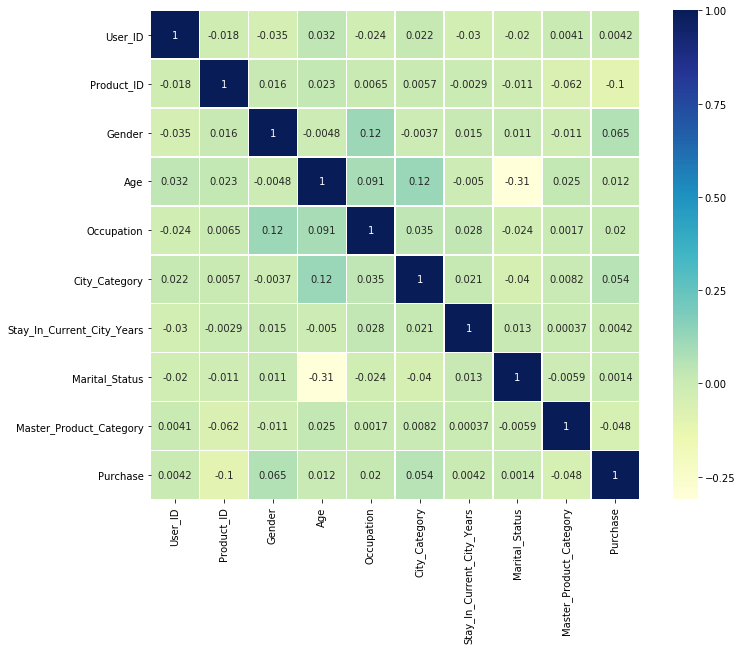

In [56]:
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=1, cmap="YlGnBu", square=True,linewidths=.5, annot=True)
plt.show()

In [57]:
# Obtaining top 5 parameters columns which affects the Purchase the most
k= 5
corrmat.nlargest(k, 'Purchase')

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Master_Product_Category,Purchase
Purchase,0.004241,-0.103676,0.065329,0.011601,0.019605,0.054228,0.004167,0.001421,-0.048005,1.000000
Gender,-0.034666,0.015883,1.000000,-0.004758,0.116505,-0.003727,0.015026,0.010945,-0.011419,0.065329
City_Category,0.021705,0.005711,-0.003727,0.123415,0.035336,1.000000,0.020564,-0.040060,0.008232,0.054228
Occupation,-0.023976,0.006529,0.116505,0.090882,1.000000,0.035336,0.028488,-0.023563,0.001679,0.019605
Age,0.032384,0.023011,-0.004758,1.000000,0.090882,0.123415,-0.004968,-0.310747,0.025413,0.011601


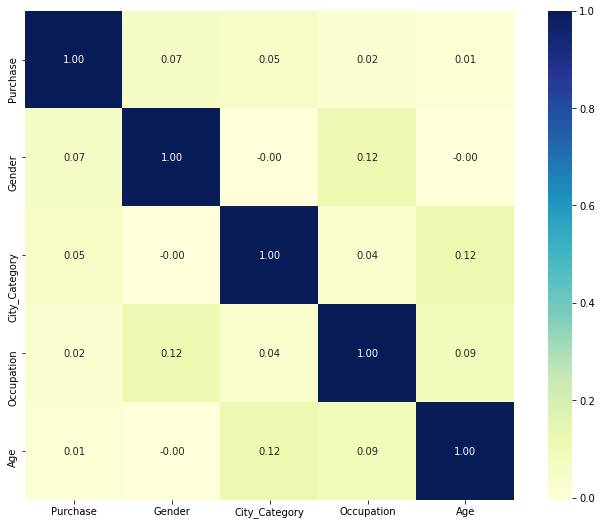

In [58]:
# Replotting the heatmap with the above data
cols = corrmat.nlargest(k, 'Purchase')['Purchase'].index
cm = np.corrcoef(dataset_cat[cols].values.T)
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(cm, cmap="YlGnBu", cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

__Modifiying categorical variable__ <br>
Combining cateogrical variables to obtain good number of counts of categorical varaibles.

In [59]:
dataset.dtypes

User_ID                         int64
Product_ID                     object
Gender                         object
Age                            object
Occupation                      int64
City_Category                  object
Stay_In_Current_City_Years      int32
Marital_Status                 object
Master_Product_Category         int32
Purchase                      float64
source                         object
Gender_MaritalStatus           object
dtype: object

In [60]:
# Building list of categorical variables to obtain details
categ_columns = list(dataset.columns.values)
categ_columns

['User_ID',
 'Product_ID',
 'Gender',
 'Age',
 'Occupation',
 'City_Category',
 'Stay_In_Current_City_Years',
 'Marital_Status',
 'Master_Product_Category',
 'Purchase',
 'source',
 'Gender_MaritalStatus']

In [61]:
# Droping Identifier values, target values and others which are necessary from the list
categ_columns = [x for x in categ_columns if x not in ['User_ID','Product_ID','Purchase','source']]

In [62]:
# Print frequency of categories
for col in categ_columns:
    print ('Frequency (Count) of Categories for varible : ', col)
    print (dataset[col].value_counts())
    print('---------------------------------------------------')

Frequency (Count) of Categories for varible :  Gender
Male      590031
Female    193636
Name: Gender, dtype: int64
---------------------------------------------------
Frequency (Count) of Categories for varible :  Age
26-35    313015
36-45    156724
18-25    141953
46-50     65278
51-55     54784
55+       30579
0-17      21334
Name: Age, dtype: int64
---------------------------------------------------
Frequency (Count) of Categories for varible :  Occupation
4     103086
0      98850
7      84127
1      67687
17     57418
20     47840
12     44448
14     38782
2      37996
16     36122
6      29102
3      25126
10     18304
5      17373
15     17356
11     16593
19     11919
13     11053
18      9367
9       8929
8       2189
Name: Occupation, dtype: int64
---------------------------------------------------
Frequency (Count) of Categories for varible :  City_Category
B    329739
C    243684
A    210244
Name: City_Category, dtype: int64
-------------------------------------------------

__Combining Age ranges__

In [63]:
dataset['Modified_Age'] = dataset[['Age']]

In [64]:
dataset['Modified_Age'].value_counts()

26-35    313015
36-45    156724
18-25    141953
46-50     65278
51-55     54784
55+       30579
0-17      21334
Name: Modified_Age, dtype: int64

In [65]:
# Modify Age Range to obtain obtain good number of counts in each range
dataset['Modified_Age'] =dataset['Modified_Age']. map({'0-17':'0-25','18-25':'0-25',
                                                       '46-50':'46-55+','51-55':'46-55+','55+':'46-55+',
                                                      '26-35':'26-35','36-45':'36-45'})

In [66]:
dataset['Modified_Age'].value_counts()

26-35     313015
0-25      163287
36-45     156724
46-55+    150641
Name: Modified_Age, dtype: int64

In [67]:
dataset['Occupation'].value_counts()

4     103086
0      98850
7      84127
1      67687
17     57418
20     47840
12     44448
14     38782
2      37996
16     36122
6      29102
3      25126
10     18304
5      17373
15     17356
11     16593
19     11919
13     11053
18      9367
9       8929
8       2189
Name: Occupation, dtype: int64

__One Hot encoding of variables__

In [68]:
dataset.columns

Index(['User_ID', 'Product_ID', 'Gender', 'Age', 'Occupation', 'City_Category',
       'Stay_In_Current_City_Years', 'Marital_Status',
       'Master_Product_Category', 'Purchase', 'source', 'Gender_MaritalStatus',
       'Modified_Age'],
      dtype='object')

In [69]:
# Categorical variables
dataset[['Occupation','City_Category','Stay_In_Current_City_Years','Gender_MaritalStatus','Modified_Age']].head()

,Occupation,City_Category,Stay_In_Current_City_Years,Gender_MaritalStatus,Modified_Age
0,10,A,2,Female_Un-Married,0-25
1,10,A,2,Female_Un-Married,0-25
2,10,A,2,Female_Un-Married,0-25
3,10,A,2,Female_Un-Married,0-25
4,16,C,4,Male_Un-Married,46-55+


In [70]:
# Feature Encoding categorical columns to visualize correlation of parameters with Purchase column
# Importing required package
from sklearn.preprocessing import LabelEncoder
encode_x = LabelEncoder()

In [71]:
# Encoding categorical columns 
dataset['City_Category'] = encode_x.fit_transform(dataset['City_Category'])
dataset['Gender_MaritalStatus'] = encode_x.fit_transform(dataset['Gender_MaritalStatus'])
dataset['Modified_Age'] = encode_x.fit_transform(dataset['Modified_Age'])

In [72]:
dataset[['Occupation','City_Category','Stay_In_Current_City_Years','Gender_MaritalStatus','Modified_Age']].head()

,Occupation,City_Category,Stay_In_Current_City_Years,Gender_MaritalStatus,Modified_Age
0,10,0,2,1,0
1,10,0,2,1,0
2,10,0,2,1,0
3,10,0,2,1,0
4,16,2,4,3,3


In [73]:
# Creating dummy variables, one for each category of a categorical variable
dataset = pd.get_dummies(dataset, columns=['Occupation', 'City_Category','Stay_In_Current_City_Years', 
                                           'Gender_MaritalStatus','Modified_Age'])

In [74]:
dataset.dtypes

User_ID                           int64
Product_ID                       object
Gender                           object
Age                              object
Marital_Status                   object
Master_Product_Category           int32
Purchase                        float64
source                           object
Occupation_0                      uint8
Occupation_1                      uint8
Occupation_2                      uint8
Occupation_3                      uint8
Occupation_4                      uint8
Occupation_5                      uint8
Occupation_6                      uint8
Occupation_7                      uint8
Occupation_8                      uint8
Occupation_9                      uint8
Occupation_10                     uint8
Occupation_11                     uint8
Occupation_12                     uint8
Occupation_13                     uint8
Occupation_14                     uint8
Occupation_15                     uint8
Occupation_16                     uint8


#### Exporting the data

In [75]:
# Drop the columns which have been converted to different types:
dataset.drop(['Age','Gender', 'Marital_Status'],axis=1,inplace=True)

In [76]:
dataset.dtypes

User_ID                           int64
Product_ID                       object
Master_Product_Category           int32
Purchase                        float64
source                           object
Occupation_0                      uint8
Occupation_1                      uint8
Occupation_2                      uint8
Occupation_3                      uint8
Occupation_4                      uint8
Occupation_5                      uint8
Occupation_6                      uint8
Occupation_7                      uint8
Occupation_8                      uint8
Occupation_9                      uint8
Occupation_10                     uint8
Occupation_11                     uint8
Occupation_12                     uint8
Occupation_13                     uint8
Occupation_14                     uint8
Occupation_15                     uint8
Occupation_16                     uint8
Occupation_17                     uint8
Occupation_18                     uint8
Occupation_19                     uint8


In [77]:
# Splitting the dataset back into test and train datasets for model building:
train = dataset.loc[dataset['source']=="train"]
test = dataset.loc[dataset['source']=="test"]

In [78]:
# Dropping unnecessary columns:
test = test.drop(['Purchase','source'],axis=1) # dropping dependent variable 'Purchase' from the test dataset
train = train.drop(['source'],axis=1)

In [79]:
test.columns

Index(['User_ID', 'Product_ID', 'Master_Product_Category', 'Occupation_0',
       'Occupation_1', 'Occupation_2', 'Occupation_3', 'Occupation_4',
       'Occupation_5', 'Occupation_6', 'Occupation_7', 'Occupation_8',
       'Occupation_9', 'Occupation_10', 'Occupation_11', 'Occupation_12',
       'Occupation_13', 'Occupation_14', 'Occupation_15', 'Occupation_16',
       'Occupation_17', 'Occupation_18', 'Occupation_19', 'Occupation_20',
       'City_Category_0', 'City_Category_1', 'City_Category_2',
       'Stay_In_Current_City_Years_0', 'Stay_In_Current_City_Years_1',
       'Stay_In_Current_City_Years_2', 'Stay_In_Current_City_Years_3',
       'Stay_In_Current_City_Years_4', 'Gender_MaritalStatus_0',
       'Gender_MaritalStatus_1', 'Gender_MaritalStatus_2',
       'Gender_MaritalStatus_3', 'Modified_Age_0', 'Modified_Age_1',
       'Modified_Age_2', 'Modified_Age_3'],
      dtype='object')

In [80]:
train.columns

Index(['User_ID', 'Product_ID', 'Master_Product_Category', 'Purchase',
       'Occupation_0', 'Occupation_1', 'Occupation_2', 'Occupation_3',
       'Occupation_4', 'Occupation_5', 'Occupation_6', 'Occupation_7',
       'Occupation_8', 'Occupation_9', 'Occupation_10', 'Occupation_11',
       'Occupation_12', 'Occupation_13', 'Occupation_14', 'Occupation_15',
       'Occupation_16', 'Occupation_17', 'Occupation_18', 'Occupation_19',
       'Occupation_20', 'City_Category_0', 'City_Category_1',
       'City_Category_2', 'Stay_In_Current_City_Years_0',
       'Stay_In_Current_City_Years_1', 'Stay_In_Current_City_Years_2',
       'Stay_In_Current_City_Years_3', 'Stay_In_Current_City_Years_4',
       'Gender_MaritalStatus_0', 'Gender_MaritalStatus_1',
       'Gender_MaritalStatus_2', 'Gender_MaritalStatus_3', 'Modified_Age_0',
       'Modified_Age_1', 'Modified_Age_2', 'Modified_Age_3'],
      dtype='object')

In [81]:
# Exporting csv files as modified versions:
train.to_csv("./BlackFriday_Outputs/train_modified.csv",index=False)
test.to_csv("./BlackFriday_Outputs/test_modified.csv",index=False)

### 4. Building the model

In [81]:
# Mean based:
mean_purhcase = train['Purchase'].mean()
mean_purhcase

9263.968712959126

In [82]:
# Defining a dataframe with IDs for submission:
base1 = test[['User_ID','Product_ID']]

In [83]:
# Implying the mean sales value to the Item_Outlet_Sales column
base1.loc[:,'Purchase'] = mean_purhcase

c:\users\nags\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
c:\users\nags\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [85]:
# Exporting the submission file
base1.to_csv("./BlackFriday_Outputs/algor0.csv",index=False)

Function to makes the model, performs cross-validation and generates submission.

In [84]:
# Make the model and perform cross validation
from sklearn.model_selection import cross_val_score
from sklearn import metrics

def modelfit_test(algorthm, dftrain, dftest, predictors, target, IDcol):

    #Fit the algorthmorithm on the data
    algorthm.fit(dftrain[predictors], dftrain[target]) 
        
    #Predict training set:
    dftrain_predictions = algorthm.predict(dftrain[predictors])

    #Perform cross-validation:
    cv_score = cross_val_score(algorthm, dftrain[predictors], dftrain[target], cv=20, n_jobs=-1,scoring='neg_mean_squared_error')
    cv_score = np.sqrt(np.abs(cv_score))
    
    #Print model report:
    print ("\n------Model Report----\n")
    print ("RMSE : " , np.sqrt(metrics.mean_squared_error(dftrain[target].values, dftrain_predictions)))
    print ("CV Score Mean : %.4g" %(np.mean(cv_score)))
    print ("CV Score Std : %.4g" %(np.std(cv_score)))
    print ("CV Score Min : %.4g" %(np.min(cv_score)))
    print ("CV Score Max : %.4g" %(np.max(cv_score)))

In [85]:
# Make the model, perform cross validation and export submission file.

from sklearn.model_selection import cross_val_score
from sklearn import metrics
def modelfit(algorthm, dftrain, dftest, predictors, target, IDcol, filename):

    #Fit the algorthmorithm on the data
    algorthm.fit(dftrain[predictors], dftrain[target]) # similar to the base dataframe created above with the predictor & target columns
        
    #Predict training set:
    dftrain_predictions = algorthm.predict(dftrain[predictors]) # Predicting using the predictors

    #Perform cross-validation:
    cv_score = cross_val_score(algorthm, dftrain[predictors], dftrain[target], cv=20, n_jobs=-1, scoring='neg_mean_squared_error')
    cv_score = np.sqrt(np.abs(cv_score))
    
    #Print model report:
    print ("\n------Model Report----\n")
    print ("RMSE : " , np.sqrt(metrics.mean_squared_error(dftrain[target].values, dftrain_predictions)))
    print ("CV Score Mean : %.4g" %(np.mean(cv_score)))
    print ("CV Score Std : %.4g" %(np.std(cv_score)))
    print ("CV Score Min : %.4g" %(np.min(cv_score)))
    print ("CV Score Max : %.4g" %(np.max(cv_score)))
    
    #Predict on testing data:
    dftest[target] = algorthm.predict(dftest[predictors])
    
    #Export submission file:
    IDcol.append(target)
    submission = pd.DataFrame({ x: dftest[x] for x in IDcol})
    submission.to_csv(filename, index=False)

## Machine Learning - Build Model

In [86]:
train.head()

,User_ID,Product_ID,Master_Product_Category,Purchase,Occupation_0,Occupation_1,Occupation_2,Occupation_3,Occupation_4,Occupation_5,...,Stay_In_Current_City_Years_3,Stay_In_Current_City_Years_4,Gender_MaritalStatus_0,Gender_MaritalStatus_1,Gender_MaritalStatus_2,Gender_MaritalStatus_3,Modified_Age_0,Modified_Age_1,Modified_Age_2,Modified_Age_3
0,1000001,P00069042,300,8370.0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
1,1000001,P00248942,1614,15200.0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
2,1000001,P00087842,1200,1422.0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
3,1000001,P00085442,12140,1057.0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
4,1000002,P00285442,800,7969.0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,1


__Assigning Targets, ID Columns and predictors__

In [87]:
# Assigning columns for model building
target = 'Purchase'
IDcol = ['User_ID','Product_ID']

# Excluding Identifiers (used for submission) and dependent variable column
predictors = [x for x in train.columns if x not in [target]+IDcol]


### Linear Regression Model

In [90]:
# Building a linear regression model 
from sklearn.linear_model import LinearRegression
alg1 = LinearRegression(normalize=True)

In [91]:
modelfit_test(alg1, train, test, predictors, target, IDcol)


------Model Report----

RMSE :  4992.114945300622
CV Score Mean : 4990
CV Score Std : 193.9
CV Score Min : 4891
CV Score Max : 5827


In [99]:
# Assigning columns for model building
target = 'Purchase'
IDcol = ['User_ID','Product_ID']

# Excluding Identifiers (used for submission) and dependent variable column
predictors = [x for x in train.columns if x not in [target]+IDcol]
alg1.fit(train[predictors], train[target])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [92]:
# Using the FUNCTION which takes the algorithm and data as input and makes the model 
modelfit(alg1, train, test, predictors, target, IDcol, 'algor1.csv')

In [122]:
coef1 = pd.Series(alg1.coef_, predictors).sort_values(ascending=True)
coef1

NameError: name 'alg1' is not defined

In [121]:
plt.figure(figsize=(8,6))
coef1.plot(kind='bar', title='Model Coefficients')
plt.show()

NameError: name 'coef1' is not defined

<Figure size 576x432 with 0 Axes>

### Ridge Regression Model:

In [94]:
# Building a list of independent varaibles to build the model
from sklearn.linear_model import Ridge

In [95]:
# Building a Ridge regression model 
alg2 = Ridge(alpha=0.05,normalize=True)

In [96]:
modelfit_test(alg2, train, test, predictors, target, IDcol)


------Model Report----

RMSE :  4992.1368336771175
CV Score Mean : 4990
CV Score Std : 193.3
CV Score Min : 4891
CV Score Max : 5824


### Decision Tree Model

In [124]:
# Building a Decision Tree regression model 
from sklearn.tree import DecisionTreeRegressor
alg3 = DecisionTreeRegressor(max_depth=25, min_samples_leaf=100)

In [125]:
modelfit_test(alg3, train, test, predictors, target, IDcol)


------Model Report----

RMSE :  2887.909556547156
CV Score Mean : 3037
CV Score Std : 456.7
CV Score Min : 2889
CV Score Max : 5025


__Evaluating best parameters by Grid Search__

In [114]:
# Importing required package
from sklearn.model_selection import GridSearchCV

In [120]:
alg3.get_params().keys()

dict_keys(['criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'presort', 'random_state', 'splitter'])

In [112]:
import sklearn.metrics
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'accuracy', 'roc_auc', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'brier_score_loss', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted'])

In [110]:
#  DecisionTreeRegressor(max_depth=15, min_samples_leaf=100)
params = [{'max_depth':[25,50,75,100],'min_samples_leaf' :[50,100,150,200]}]

In [115]:
grid_search = GridSearchCV(estimator = alg3, 
                           param_grid = params,
                           scoring = 'neg_mean_squared_error',
                           cv = 20,
                           n_jobs= -1)

In [116]:
grid_search.fit(train[predictors], train[target])

GridSearchCV(cv=20, error_score='raise-deprecating',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=50, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=50,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'max_depth': [25, 50, 75, 100], 'min_samples_leaf': [50, 100, 150, 200]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [117]:
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

In [118]:
best_accuracy

-9413541.90026217

In [119]:
best_parameters

{'max_depth': 50, 'min_samples_leaf': 50}

In [105]:
# Building a Decision Tree regression model with the above values
from sklearn.tree import DecisionTreeRegressor
alg3_1 = DecisionTreeRegressor(max_depth=50, min_samples_leaf=50)

In [109]:
modelfit(alg3, train, test, predictors, target, IDcol,'./BlackFriday_Outputs/algor3_29_12.csv')


------Model Report----

RMSE :  2858.1558704945296
CV Score Mean : 3036
CV Score Std : 440.4
CV Score Min : 2892
CV Score Max : 4954


In [130]:
coef3

Master_Product_Category         0.987567
City_Category_2                 0.004014
Modified_Age_0                  0.000727
Modified_Age_3                  0.000718
Gender_MaritalStatus_3          0.000678
Stay_In_Current_City_Years_1    0.000530
Modified_Age_1                  0.000518
Gender_MaritalStatus_2          0.000493
City_Category_0                 0.000439
Modified_Age_2                  0.000415
City_Category_1                 0.000378
Stay_In_Current_City_Years_3    0.000283
Occupation_1                    0.000280
Gender_MaritalStatus_1          0.000277
Occupation_20                   0.000263
Stay_In_Current_City_Years_0    0.000261
Stay_In_Current_City_Years_2    0.000252
Occupation_0                    0.000251
Occupation_7                    0.000233
Stay_In_Current_City_Years_4    0.000231
Gender_MaritalStatus_0          0.000227
Occupation_4                    0.000163
Occupation_12                   0.000157
Occupation_17                   0.000134
Occupation_10   

The RMSE value is 3424 and the cross validation mean score is 3525.
This indicates that there is __over-fitting__ of the model

### Random Forest Model

In [116]:
target = 'Purchase'
IDcol = ['User_ID','Product_ID']
predictors = [x for x in train.columns if x not in [target]+IDcol]

In [117]:
from sklearn.ensemble import RandomForestRegressor
alg5 = RandomForestRegressor(n_estimators=50,max_depth=25, min_samples_leaf=50,n_jobs=1)

In [118]:
modelfit_test(alg5, train, test, predictors, target, IDcol)


------Model Report----

RMSE :  2859.1490578045723
CV Score Mean : 3016
CV Score Std : 446.5
CV Score Min : 2873
CV Score Max : 4960


In [119]:
target = 'Purchase'
IDcol = ['User_ID','Product_ID']
# Making a decision tree with just **top 2** variables based on the above coeffecient values
predictors = ['Master_Product_Category','City_Category_2']

In [120]:
modelfit_test(alg5, train, test, predictors, target, IDcol)


------Model Report----

RMSE :  2925.346941075561
CV Score Mean : 3042
CV Score Std : 457
CV Score Min : 2902
CV Score Max : 5032
